# PML Project

Data: 2022-01-15

Author: Jiajun He

Content: Structured Parameterization of the Decoder Networks, but no prior on these parameters. Also exploring overfitting at the same time

In [ ]:
!wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta

--2022-01-15 11:34:20--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2441075 (2.3M)
Saving to: ‘BLAT_ECOLX_1_b0.5_labeled.fasta’

BLAT_ECOLX_1_b0.5_l 100%[===================>]   2.33M  3.04MB/s    in 0.8s    

2022-01-15 11:34:21 (3.04 MB/s) - ‘BLAT_ECOLX_1_b0.5_labeled.fasta’ saved [2441075/2441075]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# parsing the FASTA file, codes from https://colab.research.google.com/github/wouterboomsma/pml_vae_project/blob/main/protein_vae_data_processing.ipynb
import os
import re
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd

# FASTA parser requires Biopython
try:
    from Bio import SeqIO
except:
    !pip install biopython
    from Bio import SeqIO
    
# Retrieve protein alignment file
if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
        
# Retrieve file with experimental measurements
if not os.path.exists('BLAT_ECOLX_Ranganathan2015.csv'):
    !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
        
# Options
batch_size = 16

# Mapping from amino acids to integers
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22}
aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-"

phyla = ['Acidobacteria', 'Actinobacteria', 'Bacteroidetes',
         'Chloroflexi', 'Cyanobacteria', 'Deinococcus-Thermus',
         'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'Other']

def get_data(data_filename, calc_weights=False, weights_similarity_threshold=0.8):
    '''Create dataset from FASTA filename'''
    ids = []
    labels = []
    seqs = []
    label_re = re.compile(r'\[([^\]]*)\]')
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)       
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
        
        label = label_re.search(record.description).group(1)
        # Only use most common classes
        if label not in phyla:
            label = 'Other'
        labels.append(label)
                
    seqs = torch.from_numpy(np.vstack(seqs))
    labels = np.array(labels)
    
    phyla_lookup_table, phyla_idx = np.unique(labels, return_inverse=True)

    dataset = torch.utils.data.TensorDataset(*[seqs, torch.from_numpy(phyla_idx)])
    
    
    weights = None
    if calc_weights is not False:

        # Experiencing memory issues on colab for this code because pytorch doesn't
        # allow one_hot directly to bool. Splitting in two and then merging.
        # one_hot = F.one_hot(seqs.long()).to('cuda' if torch.cuda.is_available() else 'cpu')
        one_hot1 = F.one_hot(seqs[:len(seqs)//2].long()).bool()
        one_hot2 = F.one_hot(seqs[len(seqs)//2:].long()).bool()
        one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
        assert(len(seqs) == len(one_hot))
        del one_hot1
        del one_hot2
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
            w = 1.0 / (similarities / lengths).gt(weights_similarity_threshold).sum(1).float()
            weights.append(w)
            
        weights = torch.cat(weights)
        neff = weights.sum()

    return dataset, weights


dataset, weights = get_data('BLAT_ECOLX_1_b0.5_labeled.fasta', calc_weights=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_weighted = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.WeightedRandomSampler(weights, num_samples=len(dataset)))

     |████████████████████████████████| 2.3 MB 5.0 MB/s 
--2022-01-15 11:36:25--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M  1.77MB/s    in 0.7s    

2022-01-15 11:36:27 (1.77 MB/s) - ‘BLAT_ECOLX_Ranganathan2015.csv’ saved [1216640/1216640]



In [ ]:
import torch
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [ ]:
global H
H = 2000

In [ ]:
class DeepSeq_MAP(nn.Module):
    def __init__(self, input_size, latent_size, device):
        super().__init__()
        self.fc11 = nn.Linear(input_size, 1500) # 1500 is the number in the papar
        self.fc12 = nn.Linear(1500, 1500)
        self.fc131 = nn.Linear(1500, latent_size)
        self.fc132 = nn.Linear(1500, latent_size)

        self.fc21 = nn.Linear(latent_size, 100)
        self.fc22 = nn.Linear(100, H)
        
        # called "XXX_loc" since in Bayesian setting, we may also need "XXX_scale"
        self.lambd_tilde_loc = nn.Parameter(torch.tensor(0.))
        self.C_loc = nn.Parameter(torch.randn(23, 40))
        self.W_tilde_loc = nn.Parameter(torch.randn(input_size//23, 40, H)) # L * E * H
        self.S_tilde_loc = nn.Parameter(torch.randn(H//4, input_size//23) * 4 - 12)
        
        self.b3 = nn.Parameter(torch.randn(input_size//23, 23))

        self.device = device
    
    def encoder(self, x):
        x = nn.functional.one_hot(x, num_classes=23).float().reshape(x.shape[0], -1)
        hidden = nn.ReLU()(self.fc11(x))
        hidden = nn.ReLU()(self.fc12(hidden))
        z_mu = self.fc131(hidden)
        z_sd = torch.exp(self.fc132(hidden))

        return z_mu, z_sd

    def decoder(self, z):
        hidden = nn.ReLU()(self.fc21(z))
        hidden = nn.Sigmoid()(self.fc22(hidden)) 
        

        lambd_tilde = self.lambd_tilde_loc
        C = self.C_loc
        S_tilde = self.S_tilde_loc
        W_tilde = self.W_tilde_loc

        S = torch.cat([1 / (torch.exp(-S_tilde.clone()) + 1) for i in range(4)], dim=0)
        hidden = hidden[:, :, np.newaxis].expand([z.shape[0], H, S.shape[-1]])
        Sh = torch.permute((hidden * S), (0, 2, 1))[:, :, :,np.newaxis] # B * L * H * 1
        hidden = torch.log(torch.exp(lambd_tilde) + 1) * C @ W_tilde @ Sh #B L q 1
        hidden = hidden[:, :, :, 0] + self.b3 #B * L * q

        return hidden
        
    
    def forward(self, x, mc_samples=1):
        z_mu, z_sd = self.encoder(x)

        # prior distribution
        prior = torch.distributions.Normal(0., 1.)
        posterior = torch.distributions.Normal(z_mu, z_sd)

        # since both prior and posterior are diag-Gaussian, the KL divergence between q(z|x) and p(z) is just the sum of the KL divergence in each dimension
        KL_post_prior = torch.sum(torch.distributions.kl.kl_divergence(posterior, prior), dim=-1)

        # E_q[p(x|z)] (sum because p(x|z) = p(x1|z)p(x2|z)...)
        z = torch.randn_like(z_mu) * z_sd + z_mu
        x_logit = self.decoder(z)
        Ep = torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        for sample in range(mc_samples-1):
            z = torch.randn_like(z_mu) * z_sd + z_mu
            x_logit = self.decoder(z)
            Ep += torch.sum(torch.distributions.Categorical(logits=x_logit).log_prob(x), dim=-1)
        Ep = Ep / mc_samples

        ELBO = torch.sum(Ep - KL_post_prior)
        

        return ELBO, z_mu, z_sd


In [ ]:
def train(model, dl, optimizer, device):
    ELBOs = []
    for i in dl:
        optimizer.zero_grad()
        ELBO, _, _ = model(i[0].to(device), mc_samples=1)
        loss = -ELBO
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        ELBOs.append(ELBO.item())
    return sum(ELBOs) / len(ELBOs)

In [ ]:
input_size = next(iter(dataloader))[0].shape[1] * 23
DEVICE = "cuda"
deepseq = DeepSeq_MAP(input_size, 30, device=DEVICE).to(DEVICE)
deepseq_dim_2 = DeepSeq_MAP(input_size, 2, device=DEVICE).to(DEVICE)

In [ ]:
# train the model
EPOCH = 100
ELBOs = []
for epoch in tqdm(range(EPOCH)):
    ELBOs.append(train(deepseq_dim_2, dataloader_weighted, Adam(deepseq_dim_2.parameters(), lr=0.0004), DEVICE))

100%|██████████| 100/100 [26:53<00:00, 16.14s/it]


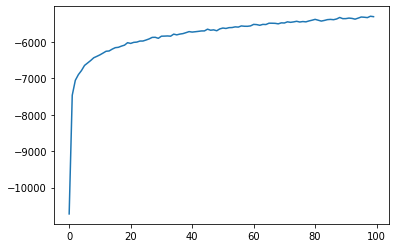

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs[:])

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "deepseq_MAP_dim_2.pkl"
# #torch.save(deepseq_dim_2.state_dict(),PATH)
# #deepseq_dim_2.load_state_dict(torch.load(PATH))

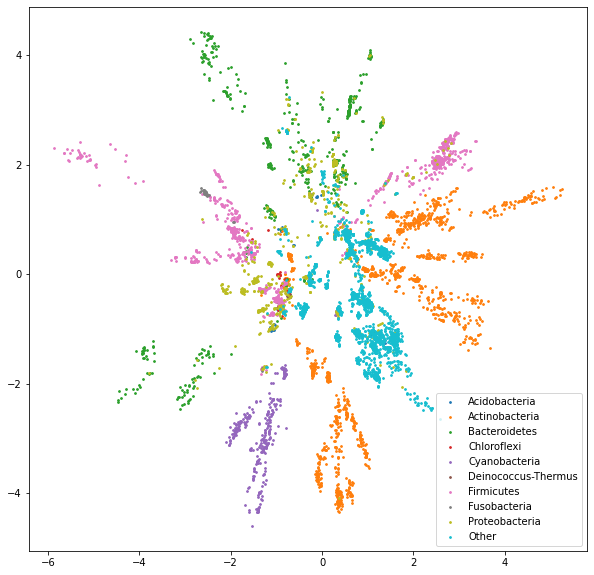

In [ ]:
Zs = []
labels = []
with torch.no_grad():
    for i in dataloader:
        z_mu, _ = deepseq_dim_2.encoder((i[0].to(DEVICE)))
        Zs.append(z_mu.cpu())
        labels.append(i[1])
Zs = torch.cat(Zs).numpy()
labels = torch.cat(labels).numpy()
plt.rcParams["figure.figsize"] = (10, 10)
for idx, name in enumerate(phyla):
    plt.scatter(Zs[labels == idx, 0], Zs[labels == idx, 1], s=3, label=name)
plt.legend()
plt.show()

In [ ]:
# train the model
EPOCH = 201
ELBOs = []
for epoch in tqdm(range(EPOCH)):
    if epoch % 10 == 0:
        print("epoch:", epoch)
        # Check the reconstruct accuracy (make sure it learns normally)
        acc = []
        for i in range(len(dataset)):
            raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
            z_mu, _ = deepseq.encoder(raw_sequence)
            acc.append(torch.argmax(deepseq.decoder(z_mu), dim=-1) == raw_sequence)
        acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
        print("Reconstruct Accuracy:", acc)


        raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
        experiment_value = []
        predicted_value = []
        with torch.no_grad():
            log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 50)
            for (position, mutant_from), row in experimental_data.iterrows():
                assert aa1_to_index[mutant_from] == raw_sequence[0, position]
                for mutant_to, exp_value in row.iteritems():
                    if mutant_to != mutant_from:
                        new_sequence = raw_sequence.clone()
                        new_sequence[0, position] = aa1_to_index[mutant_to]
                        experiment_value.append(exp_value)
                        log_x_mt_ELBO, _, _ = deepseq(new_sequence, 50)
                        predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())
        print(spearmanr(experiment_value, predicted_value))
        PATH = "/content/drive/MyDrive/PML-project/SP_no_prior/" + "deepseq_%d.pkl"%epoch
        torch.save(deepseq.state_dict(),PATH)

    ELBOs.append(train(deepseq, dataloader_weighted, Adam(deepseq.parameters(), lr=0.0001), DEVICE))

  0%|          | 0/201 [00:00<?, ?it/s]

epoch: 0
Reconstruct Accuracy: 0.04201123427753745
SpearmanrResult(correlation=-0.04250087060246139, pvalue=0.002656072522835201)


  5%|▍         | 10/201 [14:55<1:20:33, 25.30s/it]

epoch: 10
Reconstruct Accuracy: 0.5801101517616332
SpearmanrResult(correlation=0.5837813504987233, pvalue=0.0)


 10%|▉         | 20/201 [29:52<1:16:24, 25.33s/it]

epoch: 20
Reconstruct Accuracy: 0.6202725970105265
SpearmanrResult(correlation=0.650414852672933, pvalue=0.0)


 15%|█▍        | 30/201 [44:52<1:12:15, 25.36s/it]

epoch: 30
Reconstruct Accuracy: 0.6472143102281562
SpearmanrResult(correlation=0.6575204635639136, pvalue=0.0)


 20%|█▉        | 40/201 [59:50<1:07:57, 25.33s/it]

epoch: 40
Reconstruct Accuracy: 0.6702427371772375
SpearmanrResult(correlation=0.6528453735335621, pvalue=0.0)


 25%|██▍       | 50/201 [1:14:48<1:03:46, 25.34s/it]

epoch: 50
Reconstruct Accuracy: 0.6875435051954171
SpearmanrResult(correlation=0.6728082020392676, pvalue=0.0)


 30%|██▉       | 60/201 [1:29:47<59:34, 25.35s/it]  

epoch: 60
Reconstruct Accuracy: 0.700427344627072
SpearmanrResult(correlation=0.6672933732230544, pvalue=0.0)


 35%|███▍      | 70/201 [1:44:46<55:20, 25.35s/it]  

epoch: 70
Reconstruct Accuracy: 0.7110779981502415
SpearmanrResult(correlation=0.6729515724850612, pvalue=0.0)


 40%|███▉      | 80/201 [1:59:45<51:07, 25.35s/it]

epoch: 80
Reconstruct Accuracy: 0.7194465072720327
SpearmanrResult(correlation=0.6663836755927794, pvalue=0.0)


 45%|████▍     | 90/201 [2:14:44<46:54, 25.35s/it]

epoch: 90
Reconstruct Accuracy: 0.7265934777592715
SpearmanrResult(correlation=0.6751975924621492, pvalue=0.0)


 50%|████▉     | 100/201 [2:29:43<42:40, 25.35s/it]

epoch: 100
Reconstruct Accuracy: 0.7328359279718775
SpearmanrResult(correlation=0.6819387280772897, pvalue=0.0)


 55%|█████▍    | 110/201 [2:44:42<38:28, 25.37s/it]

epoch: 110
Reconstruct Accuracy: 0.737456931068381
SpearmanrResult(correlation=0.6746525630470606, pvalue=0.0)


 60%|█████▉    | 120/201 [2:59:43<34:21, 25.46s/it]

epoch: 120
Reconstruct Accuracy: 0.742278130774436
SpearmanrResult(correlation=0.6812856411667166, pvalue=0.0)


 65%|██████▍   | 130/201 [3:14:42<29:59, 25.35s/it]

epoch: 130
Reconstruct Accuracy: 0.747260263348218
SpearmanrResult(correlation=0.6766395153987596, pvalue=0.0)


 70%|██████▉   | 140/201 [3:29:40<25:45, 25.34s/it]

epoch: 140
Reconstruct Accuracy: 0.7502724225050074
SpearmanrResult(correlation=0.6781002447453426, pvalue=0.0)


 75%|███████▍  | 150/201 [3:44:38<21:32, 25.34s/it]

epoch: 150
Reconstruct Accuracy: 0.754109604977673
SpearmanrResult(correlation=0.6791189034009221, pvalue=0.0)


 80%|███████▉  | 160/201 [3:59:38<17:22, 25.42s/it]

epoch: 160
Reconstruct Accuracy: 0.7581634651367057
SpearmanrResult(correlation=0.6710048110899777, pvalue=0.0)


 85%|████████▍ | 170/201 [4:14:40<13:08, 25.44s/it]

epoch: 170
Reconstruct Accuracy: 0.7599560246091561
SpearmanrResult(correlation=0.6772030944378503, pvalue=0.0)


 90%|████████▉ | 180/201 [4:29:41<08:54, 25.44s/it]

epoch: 180
Reconstruct Accuracy: 0.7636356673769688
SpearmanrResult(correlation=0.6668982988358795, pvalue=0.0)


 95%|█████████▍| 190/201 [4:44:42<04:39, 25.38s/it]

epoch: 190
Reconstruct Accuracy: 0.7651441706431305
SpearmanrResult(correlation=0.6748168440205655, pvalue=0.0)


100%|█████████▉| 200/201 [4:59:42<00:25, 25.38s/it]

epoch: 200
Reconstruct Accuracy: 0.7682886631519963
SpearmanrResult(correlation=0.6712130971973714, pvalue=0.0)


100%|██████████| 201/201 [5:12:16<00:00, 93.22s/it] 


In [ ]:
EPOCH = 301
for epoch in tqdm(range(201, EPOCH)):
    if epoch % 10 == 0:
        print("epoch:", epoch)
        # Check the reconstruct accuracy (make sure it learns normally)
        acc = []
        for i in range(len(dataset)):
            raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
            z_mu, _ = deepseq.encoder(raw_sequence)
            acc.append(torch.argmax(deepseq.decoder(z_mu), dim=-1) == raw_sequence)
        acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
        print("Reconstruct Accuracy:", acc)


        raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
        experiment_value = []
        predicted_value = []
        with torch.no_grad():
            log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 50)
            for (position, mutant_from), row in experimental_data.iterrows():
                assert aa1_to_index[mutant_from] == raw_sequence[0, position]
                for mutant_to, exp_value in row.iteritems():
                    if mutant_to != mutant_from:
                        new_sequence = raw_sequence.clone()
                        new_sequence[0, position] = aa1_to_index[mutant_to]
                        experiment_value.append(exp_value)
                        log_x_mt_ELBO, _, _ = deepseq(new_sequence, 50)
                        predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())
        print(spearmanr(experiment_value, predicted_value))
        PATH = "/content/drive/MyDrive/PML-project/SP_no_prior/" + "deepseq_%d.pkl"%epoch
        torch.save(deepseq.state_dict(),PATH)

    ELBOs.append(train(deepseq, dataloader_weighted, Adam(deepseq.parameters(), lr=0.0001), DEVICE))

  9%|▉         | 9/100 [02:26<24:39, 16.26s/it]

epoch: 210
Reconstruct Accuracy: 0.7691723397118332
SpearmanrResult(correlation=0.6620446653242475, pvalue=0.0)


 19%|█▉        | 19/100 [17:27<33:57, 25.16s/it]

epoch: 220
Reconstruct Accuracy: 0.7723148932704855
SpearmanrResult(correlation=0.6634898087598506, pvalue=0.0)


 29%|██▉       | 29/100 [32:27<30:03, 25.40s/it]

epoch: 230
Reconstruct Accuracy: 0.7744903954101171
SpearmanrResult(correlation=0.6559937992223893, pvalue=0.0)


 39%|███▉      | 39/100 [47:27<25:47, 25.37s/it]

epoch: 240
Reconstruct Accuracy: 0.7756009291449424
SpearmanrResult(correlation=0.6703565316285295, pvalue=0.0)


 49%|████▉     | 49/100 [1:02:27<21:33, 25.37s/it]

epoch: 250
Reconstruct Accuracy: 0.7790401420862717
SpearmanrResult(correlation=0.6394620220208531, pvalue=0.0)


 59%|█████▉    | 59/100 [1:17:27<17:21, 25.39s/it]

epoch: 260
Reconstruct Accuracy: 0.7801797600743006
SpearmanrResult(correlation=0.6569108421927101, pvalue=0.0)


 69%|██████▉   | 69/100 [1:32:28<13:07, 25.40s/it]

epoch: 270
Reconstruct Accuracy: 0.782081870233818
SpearmanrResult(correlation=0.655938084834657, pvalue=0.0)


 79%|███████▉  | 79/100 [1:47:29<08:55, 25.48s/it]

epoch: 280
Reconstruct Accuracy: 0.7826218678682988
SpearmanrResult(correlation=0.6702559567458427, pvalue=0.0)


 89%|████████▉ | 89/100 [2:02:31<04:39, 25.43s/it]

epoch: 290
Reconstruct Accuracy: 0.7855302931886617
SpearmanrResult(correlation=0.6485288772741785, pvalue=0.0)


 99%|█████████▉| 99/100 [2:17:32<00:25, 25.41s/it]

epoch: 300
Reconstruct Accuracy: 0.7870072885138528
SpearmanrResult(correlation=0.6593189588776777, pvalue=0.0)


100%|██████████| 100/100 [2:30:07<00:00, 90.08s/it] 


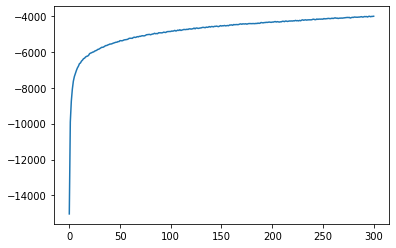

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(ELBOs[:])

In [ ]:
# PATH = "/content/drive/MyDrive/PML-project/" + "deepseq_MAP.pkl"
# #torch.save(deepseq.state_dict(),PATH)
# #deepseq.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# Check the reconstruct accuracy (make sure it learns normally)
acc = []
for i in range(len(dataset)):
    raw_sequence = dataset[i][0][np.newaxis, :].to(DEVICE)
    z_mu, _ = deepseq.encoder(raw_sequence)
    acc.append(torch.argmax(deepseq.decoder(z_mu), dim=-1) == raw_sequence)
acc = np.mean(torch.cat(acc, dim=0).cpu().numpy())
print("Reconstruct Accuracy:", acc)

In [ ]:
! wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv

# Read in the experimental data, codes by Wooter from https://colab.research.google.com/github/wouterboomsma/pml_vae_project/blob/main/protein_vae_data_processing.ipynb

def read_experimental_data(filename, alignment_data, measurement_col_name = '2500', sequence_offset=0):
    '''Read experimental data from csv file, and check that amino acid match those 
       in the first sequence of the alignment.
       
       measurement_col_name specifies which column in the csv file contains the experimental 
       observation. In our case, this is the one called 2500.
       
       sequence_offset is used in case there is an overall offset between the
       indices in the two files.
       '''
    
    measurement_df = pd.read_csv(filename, delimiter=',', usecols=['mutant', measurement_col_name])
    
    wt_sequence, wt_label = alignment_data[0]
    
    zero_index = None
    
    experimental_data = {}
    for idx, entry in measurement_df.iterrows():
        mutant_from, position, mutant_to = entry['mutant'][:1],int(entry['mutant'][1:-1]),entry['mutant'][-1:]  
        
        # Use index of first entry as offset (keep track of this in case 
        # there are index gaps in experimental data)
        if zero_index is None:
            zero_index = position
            
        # Corresponding position in our alignment
        seq_position = position-zero_index+sequence_offset
            
        # Make sure that two two inputs agree on the indices: the 
        # amino acids in the first entry of the alignment should be 
        # identical to those in the experimental file.
        assert mutant_from == aa1[wt_sequence[seq_position]]  
        
        if seq_position not in experimental_data:
            experimental_data[seq_position] = {}
        
        # Check that there is only a single experimental value for mutant
        assert mutant_to not in experimental_data[seq_position]
        
        experimental_data[seq_position]['pos'] = seq_position
        experimental_data[seq_position]['WT'] = mutant_from
        experimental_data[seq_position][mutant_to] = entry[measurement_col_name]
    
    experimental_data = pd.DataFrame(experimental_data).transpose().set_index(['pos', 'WT'])
    return experimental_data
        
        
experimental_data = read_experimental_data("BLAT_ECOLX_Ranganathan2015.csv", dataset)
# For each of the entries in the dataframe above, you should calculate
# the corresponding difference in ELBO from your VAE, and then finally
# calculate a Spearman correlation between the two.

# # You can iterate over all experimental values like this:
# for (position, mutant_from), row in experimental_data.iterrows():
#     print(position, mutant_from)   # mutant from is the wild type (wt)
#     for mutant_to, exp_value in row.iteritems():
#         print("\t", mutant_to, exp_value) 

--2022-01-15 12:54:56--  https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_Ranganathan2015.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216640 (1.2M) [text/csv]
Saving to: ‘BLAT_ECOLX_Ranganathan2015.csv.1’

BLAT_ECOLX_Ranganat 100%[===================>]   1.16M   141KB/s    in 8.4s    

2022-01-15 12:55:07 (141 KB/s) - ‘BLAT_ECOLX_Ranganathan2015.csv.1’ saved [1216640/1216640]



In [ ]:
raw_sequence = dataset[0][0][np.newaxis, :].to(DEVICE)
experiment_value = []
predicted_value = []
with torch.no_grad():
    log_x_wt_ELBO, _, _ = deepseq(raw_sequence, 100)
    for (position, mutant_from), row in tqdm(experimental_data.iterrows()):
        assert aa1_to_index[mutant_from] == raw_sequence[0, position]
        for mutant_to, exp_value in row.iteritems():
            if mutant_to != mutant_from:
                new_sequence = raw_sequence.clone()
                new_sequence[0, position] = aa1_to_index[mutant_to]
                experiment_value.append(exp_value)
                log_x_mt_ELBO, _, _ = deepseq(new_sequence, 100)
                predicted_value.append((log_x_mt_ELBO - log_x_wt_ELBO).item())

263it [23:44,  5.42s/it]


In [ ]:
spearmanr(experiment_value, predicted_value)

SpearmanrResult(correlation=0.6957418166369738, pvalue=0.0)